<a href="https://colab.research.google.com/github/divya1417/CodeClauseIntership/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload('stores_sales_forcesting.csv')

Saving stores_sales_forecasting.csv to stores_sales_forcesting.csv/stores_sales_forecasting.csv


DataFrame loaded and 'ORDERDATE' set as index.


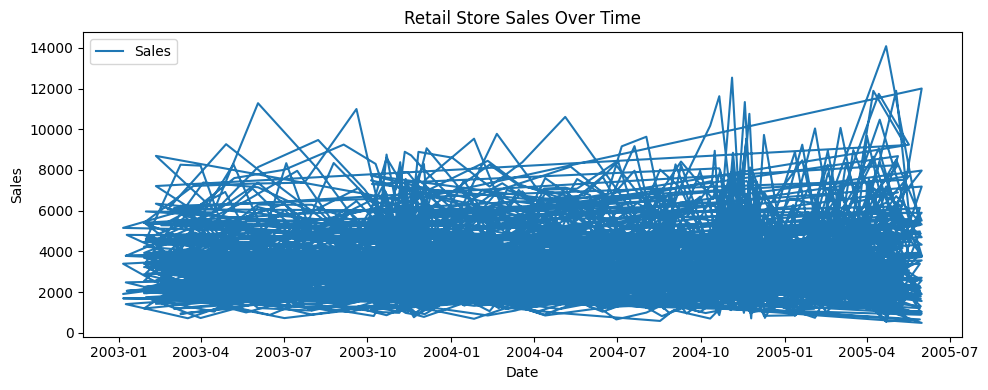


Checking for stationarity:
ADF Statistic: -6.826767865419283
p-value: 1.9389359998347743e-09
Data is stationary

Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted.
                               SARIMAX Results                                
Dep. Variable:                  SALES   No. Observations:                 2823
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -24740.834
Date:                Mon, 23 Jun 2025   AIC                          49487.668
Time:                        16:28:18   BIC                          49505.504
Sample:                             0   HQIC                         49494.104
                               - 2823                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0410      0.020

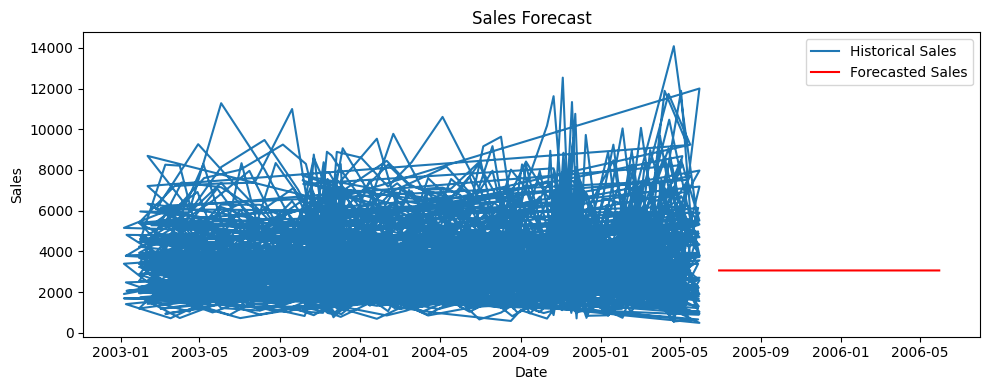


Forecasted Sales for Next 12 Periods:
2823    3059.571142
2824    3058.757084
2825    3058.723731
2826    3058.722364
2827    3058.722308
2828    3058.722306
2829    3058.722306
2830    3058.722306
2831    3058.722306
2832    3058.722306
2833    3058.722306
2834    3058.722306
Name: predicted_mean, dtype: float64


In [8]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load dataset
# Replace with your dataset path
try:
    # Load the dataset, parsing 'ORDERDATE' as dates and setting it as the index
    df = pd.read_csv("/content/archive (3).zip", encoding='latin-1')

    # Convert 'ORDERDATE' to datetime and set it as index
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
    df.set_index('ORDERDATE', inplace=True)

    print("DataFrame loaded and 'ORDERDATE' set as index.")


    # Step 2: Visualize the time series
    plt.figure(figsize=(10, 4))
    plt.plot(df['SALES'], label='Sales')
    plt.title("Retail Store Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 3: Check for stationarity
    def test_stationarity(timeseries):
        result = adfuller(timeseries)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        if result[1] <= 0.05:
            print("Data is stationary")
        else:
            print("Data is non-stationary")
            print("Consider differencing the data.")

    # Only test stationarity if df was loaded successfully and has a time series column
    if 'SALES' in df.columns:
        print("\nChecking for stationarity:")
        test_stationarity(df['SALES'])

        # Step 4: Differencing if non-stationary (if needed based on test_stationarity output)
        # If the p-value from the ADF test is > 0.05, you should difference the data.
        # For ARIMA(p,d,q), 'd' is the differencing order. If test_stationarity indicates non-stationarity
        # and you difference once to make it stationary, 'd' would likely be 1.
        # Example differencing:
        # df_diff = df['SALES'].diff().dropna()
        # print("\nChecking stationarity of differenced data:")
        # test_stationarity(df_diff)


        # Step 5: ARIMA modeling
        # (p,d,q) values depend on your data's ACF/PACF plots and stationarity.
        # (1,1,1) is a common starting point but may need adjustment.
        # 'd' in (p,d,q) should match the differencing order needed for stationarity.
        arima_order = (1,1,1)
        print(f"\nFitting ARIMA model with order {arima_order}...")
        model = ARIMA(df['SALES'], order=arima_order)
        model_fit = model.fit()
        print("ARIMA model fitted.")
        print(model_fit.summary())


        # Step 6: Forecasting
        forecast_steps = 12  # Next 12 periods
        print(f"\nForecasting for next {forecast_steps} steps...")
        forecast = model_fit.forecast(steps=forecast_steps)
        print("Forecasting complete.")


        # Step 7: Visualizing forecast
        # Ensure model_fit and forecast exist before plotting
        if 'model_fit' in locals() and 'forecast' in locals():
            plt.figure(figsize=(10, 4))
            plt.plot(df.index, df['SALES'], label='Historical Sales')
            # Create a date range for the forecast. Attempt to use the inferred frequency.
            # If frequency is None, try resampling the original data to infer a frequency or use a default.
            if df.index.freq is None:
                 # Attempt to infer frequency by resampling, e.g., monthly ('M')
                 # You might need to adjust this based on the actual frequency of your data
                 print("Could not infer frequency from index. Attempting to resample to 'M' to determine frequency for forecast index.")
                 try:
                    # Resample to monthly to get a regular time index
                    df_resampled = df['SALES'].resample('M').mean().dropna() # Using mean, adjust as needed
                    if df_resampled.index.freq is not None:
                         print(f"Inferred frequency after resampling: {df_resampled.index.freq}")
                         forecast_index = pd.date_range(df_resampled.index[-1], periods=forecast_steps + 1, freq=df_resampled.index.freq)[1:]
                    else:
                         print("Could not infer frequency even after resampling. Using a simple date range starting from the last date with daily frequency.")
                         forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:] # Fallback
                 except Exception as e:
                     print(f"Error during resampling or frequency inference: {e}. Using a simple date range starting from the last date with daily frequency.")
                     forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:] # Fallback
            else:
                print(f"Inferred frequency from index: {df.index.freq}")
                forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq=df.index.freq)[1:]


            # Ensure the length of the forecast index matches the forecast
            if len(forecast_index) != len(forecast):
                 print(f"Warning: Length of forecast index ({len(forecast_index)}) does not match length of forecast ({len(forecast)}). Adjusting forecast index length.")
                 forecast_index = forecast_index[:len(forecast)] # Trim or pad index to match forecast length


            plt.plot(forecast_index, forecast, label='Forecasted Sales', color='red')
            plt.title("Sales Forecast")
            plt.xlabel("Date")
            plt.ylabel("Sales")
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Optional: Print forecasted values
            print("\nForecasted Sales for Next 12 Periods:")
            print(forecast)
    else:
        print("ARIMA model was not fitted or forecast not generated.")

except FileNotFoundError:
    print("Error: Dataset file not found. Please check the path.")
except UnicodeDecodeError:
    print("UnicodeDecodeError: Try a different encoding, e.g., encoding='cp1252'")
except Exception as e:
    print(f"An error occurred: {e}")

In [9]:
pip install pandas matplotlib statsmodels
